# The purpose of this notebook is to classify the cell type of a ".hic" file into one of the following categories:
*   Uterine Cervix
*   Colon
*   Blood Cell
*   Skin Fibroblast
*   B Lymphocyte
*   Stem Cell
---
The core pipeline operates as follows:
1.   User uploads HIC file or uses default HIC file as an example
2.   HIC file is processsed (Computer Vision or TAD Frequency)
3.   Models predict based on processed HIC files

This colab script offers 2 classification types: Computer Vision and TAD Frequency.

1) The Computer Vision approach involves creating a heatmap from the given .hic file and using a Neural Network framework to classify the heatmap into one of the 6 cell types based on previously trained heatmaps.
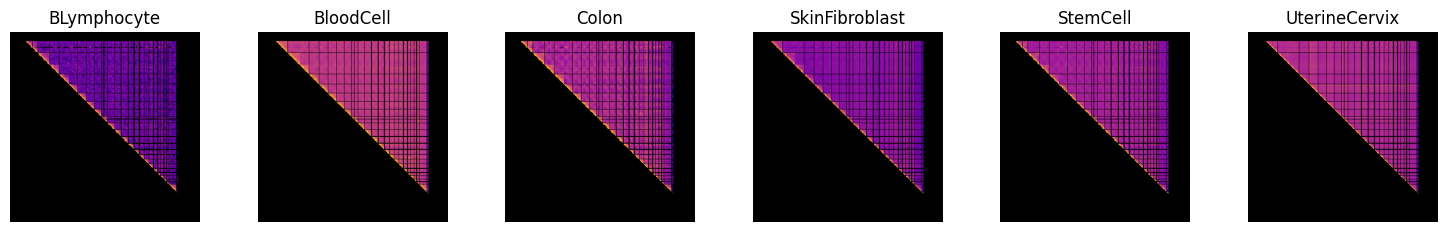

Quick Statistics:

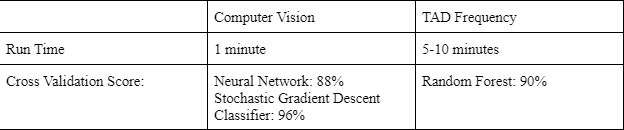

2) The TAD Frequency approach utilizes a derivative of the one-hot encoding scheme coined as frequency encoding where insulation scores are used to quantify TAD strength as well as presence. Utilizing a Random Forest model trained on previously generated frequency encoding schemes, our pipeline is able to generate and classify the encoding scheme into one of the 6 cell types.

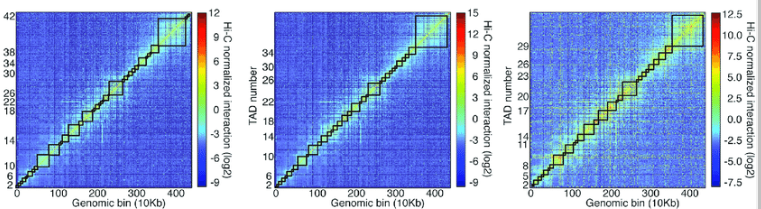





---



*As you navigate this notebook, please follow the instructions underneath each subheading. Please do not run all cells at once, as cells need to be run individually.*


# Upload Confirmation
Run these cells and continue to the next section.
These cells do not need to be opened.
An error is designed to occur if models.zip and user_files.zip are not uploaded properly. If this error does occur, please ensure you have uploaded the "models.zip" and "user_files.zip" to the colab environment.

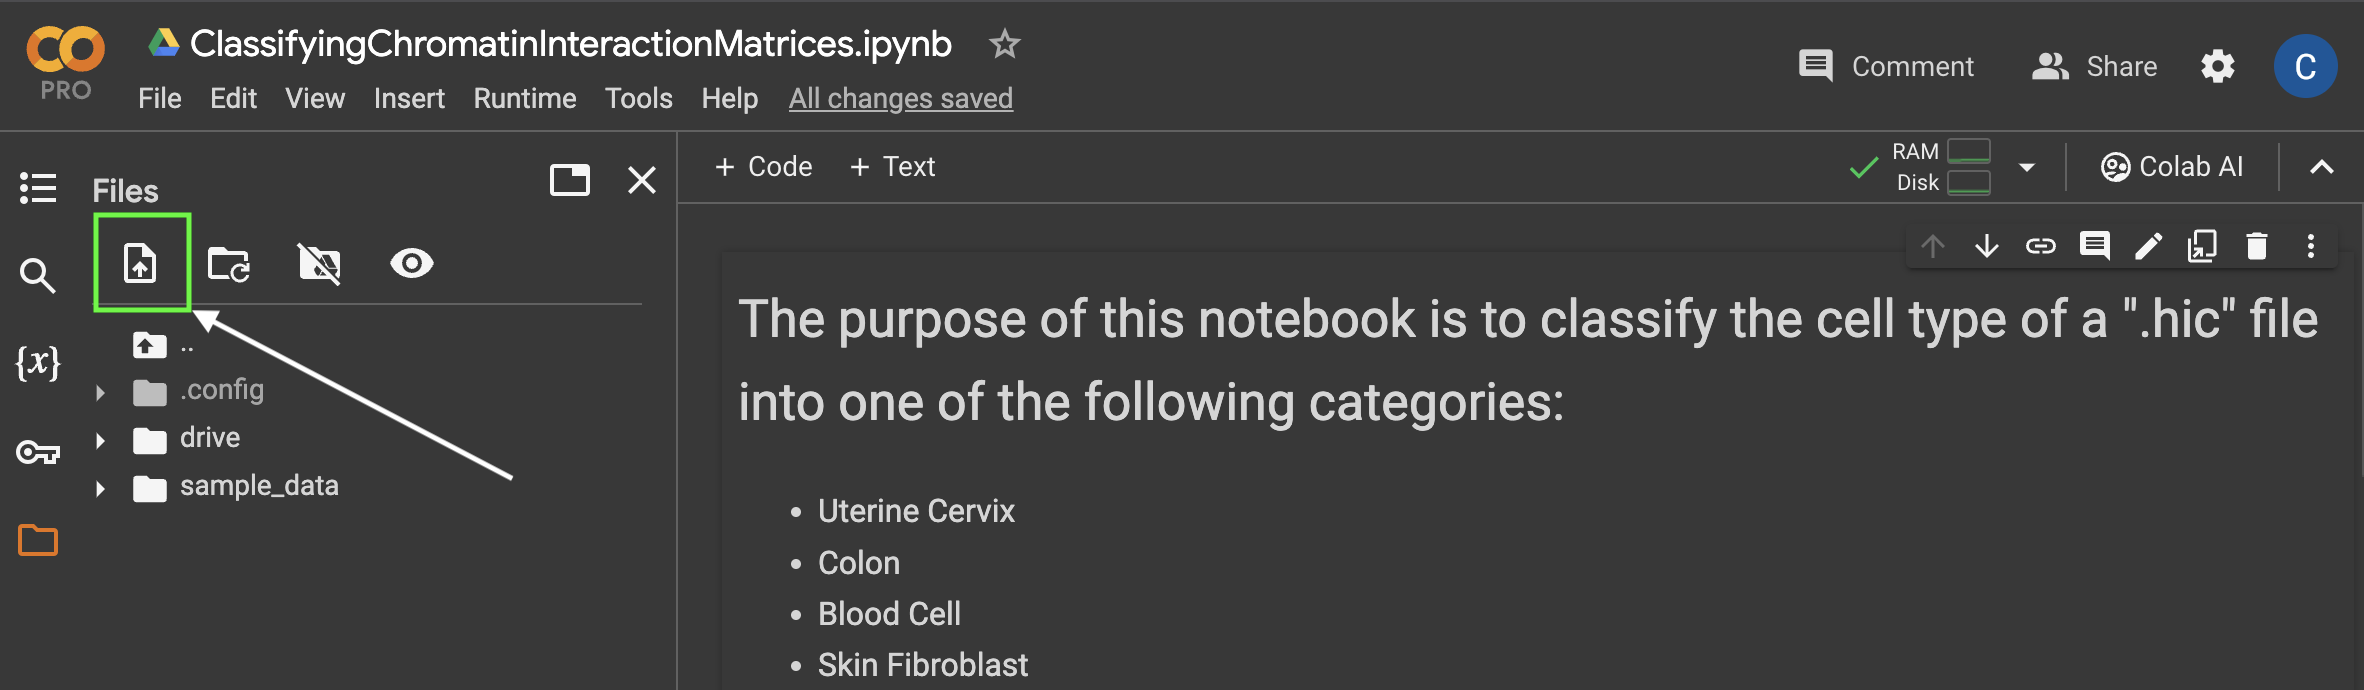

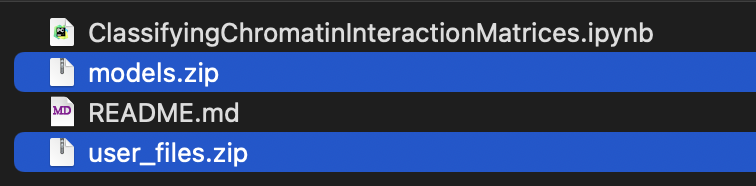

In [1]:
import os
if not os.path.exists("/content/models.zip") or not os.path.exists("/content/user_files.zip"):
  raise Exception("Please use the above directions to reload models.zip and user_files.zip to the colab environment")

!unzip models.zip
!unzip user_files.zip

Archive:  models.zip
   creating: models/
  inflating: __MACOSX/._models       
  inflating: models/scaler.pkl       
  inflating: __MACOSX/models/._scaler.pkl  
  inflating: models/.DS_Store        
  inflating: __MACOSX/models/._.DS_Store  
  inflating: models/neuralModel.pkl  
  inflating: __MACOSX/models/._neuralModel.pkl  
  inflating: models/linearModel3.pkl  
  inflating: __MACOSX/models/._linearModel3.pkl  
  inflating: models/linearModel.pkl  
  inflating: __MACOSX/models/._linearModel.pkl  
Archive:  user_files.zip
   creating: user_files/
  inflating: __MACOSX/._user_files   
  inflating: user_files/chrom_boundaries.py  
  inflating: __MACOSX/user_files/._chrom_boundaries.py  
  inflating: user_files/finalized_model.pkl  
  inflating: __MACOSX/user_files/._finalized_model.pkl  
  inflating: user_files/frequency_encoding.py  
  inflating: __MACOSX/user_files/._frequency_encoding.py  
  inflating: user_files/processing.sh  
  inflating: __MACOSX/user_files/._processing.sh  
  

#Package Installation
Run cells and continue to next section. This will restart the runtime. After the runtime restarts, continue to "Loading the file".

These cells do not need to be opened.

In [2]:
!pip install fanc
!pip install texttable
!pip install -U scikit-learn
!pip install natsort
!pip install IPython

In [4]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:39
🔁 Restarting kernel...


#Package Installation Part 2
Please run these cells. 

These cells do not need to be opened.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
import joblib
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage

import os
import subprocess
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
import pickle as pkl
from texttable import Texttable
import matplotlib.pyplot as plt
import fanc.plotting as fancplot
from skimage import io, img_as_ubyte,color
import cv2
from numpy.linalg import norm
import numpy as np
import pandas as pd
import fanc.plotting as fancplot
import plotly.express as px
import plotly.subplots as sp
import skimage
from skimage.util import crop
import plotly
from PIL import Image

#Loading the File

Please open these cells to load your file.


## Pasting a .hic URL from the 4D Nucleome Portal

Please open and run the following cells as instructed if you would like to use a ".hic" file from the 4DNucleome Data Portal.

If you would like to upload your own file, please skip to the next set of cells called "Local File Upload".



1.   Navigate to this [link](https://data.4dnucleome.org/browse/?experiments_in_set.biosample.tissue_organ_info.tissue_source=stem+cell&experiments_in_set.biosample.tissue_organ_info.tissue_source=uterine+cervix&experiments_in_set.biosample.tissue_organ_info.tissue_source=colon&experiments_in_set.biosample.tissue_organ_info.tissue_source=B-lymphocyte&experiments_in_set.biosample.tissue_organ_info.tissue_source=skin+fibroblast&experiments_in_set.biosample.tissue_organ_info.tissue_source=blood+cell&experiments_in_set.experiment_type.display_title=in+situ+Hi-C&experiments_in_set.experiment_type.display_title=Dilution+Hi-C&experiments_in_set.experiment_type.display_title=Micro-C&experiments_in_set.experiment_type.display_title=DNase+Hi-C&experiments_in_set.experiment_type.display_title=TCC&experiments_in_set.experiment_type.experiment_category=Sequencing&experimentset_type=replicate&type=ExperimentSetReplicate)

2.  After navigating to this page select one of the rows (experiments) by clicking one of  the cells under the column "Title"
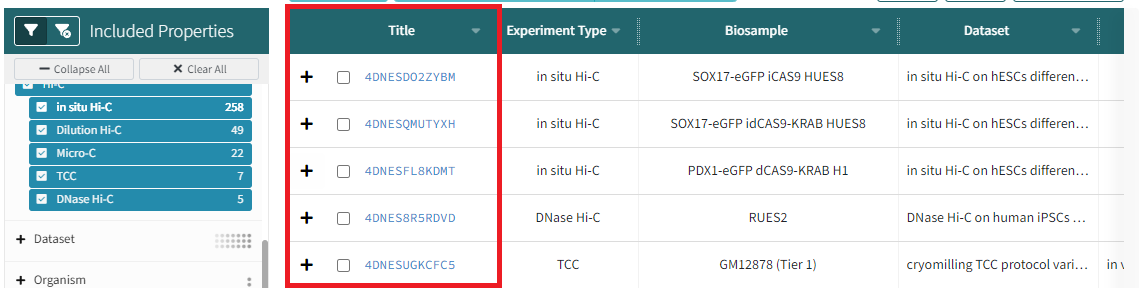

3.  The new page will be for the experiment selected. The bottom right of the new page will have another table with the section title "Processed Files". From this table select the file with the file type contact matrix (hic).
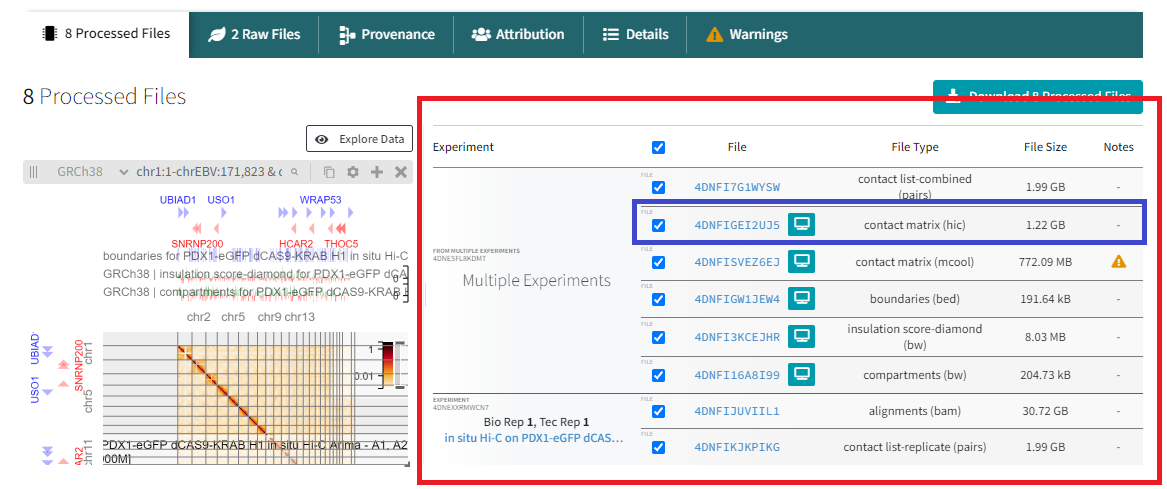

4. The new page should have a similair format to the one below. Paste the url into the following cell.
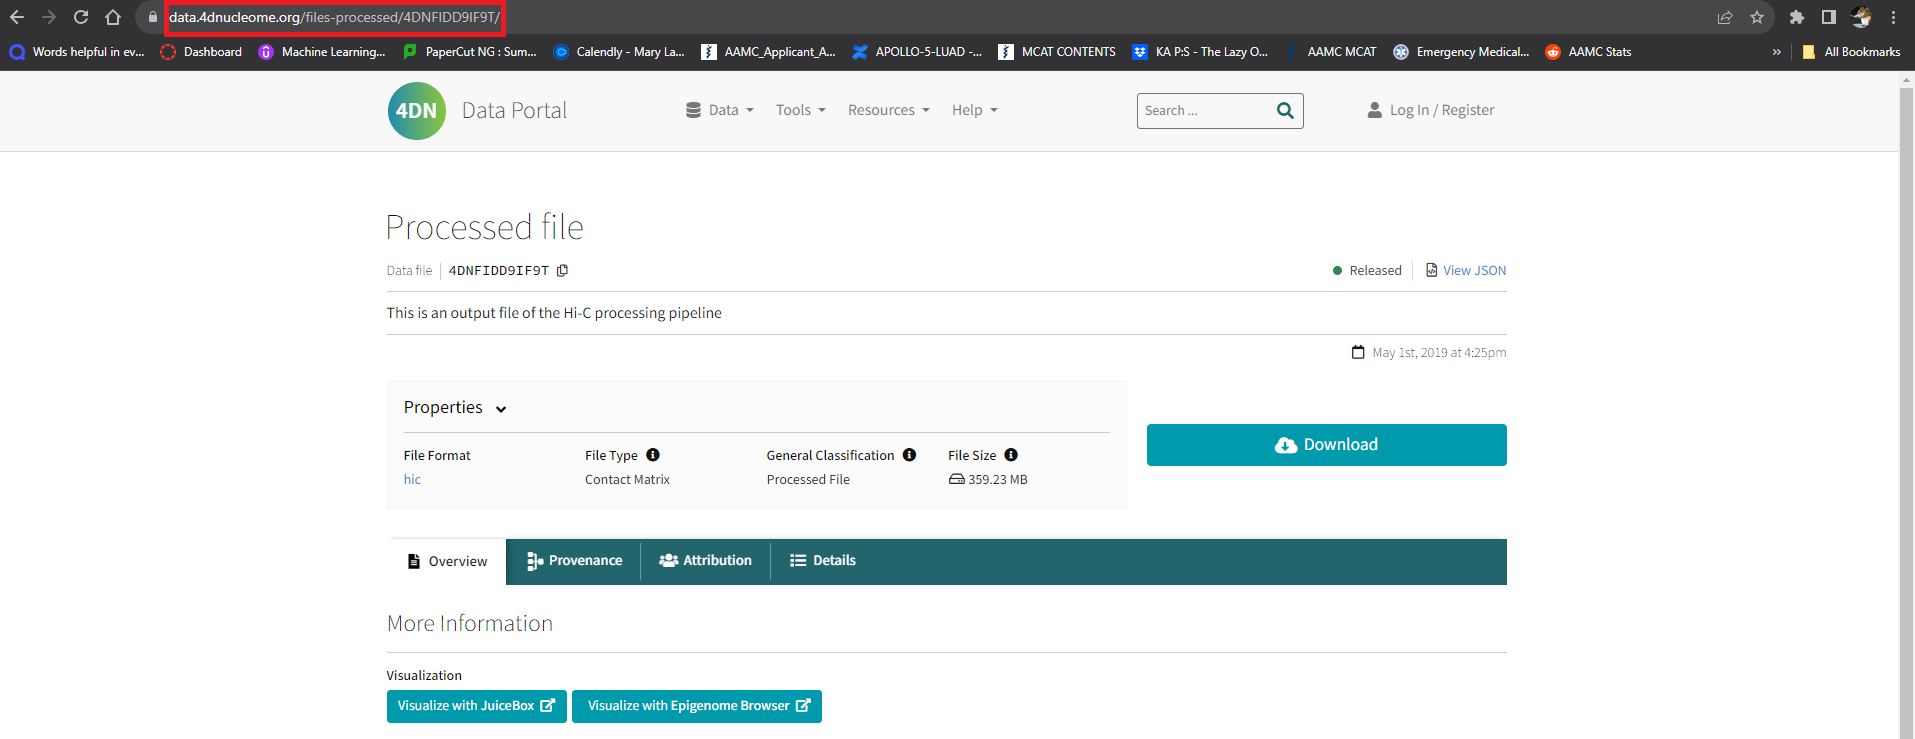

In [3]:
import ipywidgets as widgets
from IPython.display import display
#metadata_2023-12-04-00h-36m.tsv
# Create a text box widget for filename input
filename_text = widgets.Text(
    value='',
    placeholder='Enter link',
    description='Link to .hic:'
)

# Function to handle user input
def handle_submit(sender):
    print("Link entered:", filename_text.value)

# Assign the function handle_submit to be called when the user hits Enter after inputting the filename
filename_text.on_submit(handle_submit)

# Display the filename input widget
print("Click enter after pasting the link in the textbox")
display(filename_text)

Click enter after pasting the link in the textbox


Text(value='', description='Link to .hic:', placeholder='Enter link')

Link entered: https://data.4dnucleome.org/files-processed/4DNFIGEI2UJ5/


After pasting the link, run the following cell to curl the HIC file. The progress on the download can be seen in the "Time Left" column.

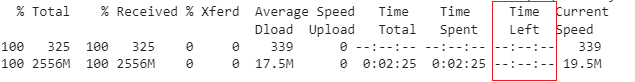

In [4]:
url = filename_text.value
if "4D" not in url:
    raise ValueError("Invalid URL")
url = url[:url.rfind('/')]
hic_file_name = url.split("/")[-1] + ".hic"
url = url + "/@@download/" + hic_file_name
print(url)
!curl -L $url --output /content/$hic_file_name --user KMXV2GYR:tvt6fgvpslvde3lu

path_to_hic = "/content/" + hic_file_name

https://data.4dnucleome.org/files-processed/4DNFIGEI2UJ5/@@download/4DNFIGEI2UJ5.hic
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   325  100   325    0     0    593      0 --:--:-- --:--:-- --:--:--   593
100 1250M  100 1250M    0     0  25.1M      0  0:00:49  0:00:49 --:--:-- 26.8M


##Local File Upload
**Only run these cells if you did not upload a file using the 4D nucleome portal.**

Please note that uploading a file from your local machine to a colab runtime environment can take an extended period time (>20 minutes) due to the large size of HIC files.

Open and run the cell within this setion then click the upload button to upload the file. Do not run any other cells within this section

In [ ]:
from ipywidgets import FileUpload
from IPython.display import display
upload = FileUpload(accept='.hic', multiple=True)
display(upload)
path_to_hic = upload.value
print(path_to_hic)

In [ ]:
print(path_to_hic)

{}


In [ ]:
from google.colab import files

# Create a file upload widget
uploaded = files.upload()

# Display the uploaded files
for filename in uploaded.keys():
    print(f'File {filename} uploaded with length {len(uploaded[filename])} bytes')


KeyboardInterrupt: ignored

# Computer Vision Approach
The following cells will create the heatmap and test the models using the HIC file you uploaded above.

The processing and model testing should run relatively quickly (<2 minutes)

This section needs to be opened.


##File Preprocessing For Computer Vision
These cells do not need to be opened, but do need to be run.

In [ ]:
#IMPORTANT PATHS
neural_model_path = '/content/models/neuralModel.pkl'
linear_model_path = '/content/models/linearModel3.pkl'
scaler_path = '/content/models/scaler.pkl'
!conda install -c conda-forge python-kaleido

Solving environment: \ | / - \ | / - \ | / - \ | / - done


==> WARNING: A newer version of conda exists. <==
  current version: 23.1.0
  latest version: 23.11.0

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.11.0



# All requested packages already installed.



In [ ]:
#Credit to  Patrick Steegstra https://kapernikov.com/tutorial-image-classification-with-scikit-learn/
from sklearn.base import BaseEstimator, TransformerMixin

class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """

    def __init__(self):
        pass

    def fit(self, X, y=None):
        """returns itself"""
        return self

    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])


class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """

    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)

        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

In [ ]:
import pickle
with open(linear_model_path, 'rb') as file:
    linear_model = pickle.load(file)
with open(neural_model_path, 'rb') as file:
    neural_model = pickle.load(file)
with open(scaler_path, 'rb') as file:
    scalify = pickle.load(file)

/usr/local/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator SGDClassifier from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MLPClassifier from version 1.2.2 when using version 1.3.2. This might lead to breaking code or in

In [ ]:
"""
displayMatrix
"""
def displayMatrix(matrix,imageName):
  displayMatrix = np.log10(matrix)
  t = pd.DataFrame(displayMatrix)
  # t.columns = testRegions
  # t.index = testRegions
  upper_triangle_t = t.where(np.triu(np.ones(t.shape)).astype(bool))
  figure1 = px.imshow(upper_triangle_t)
  figure1.update_layout(showlegend=False)
  figure1.update_yaxes(visible=False, showticklabels=False)
  figure1.update_xaxes(visible=False, showticklabels=False)
  figure1.write_image(imageName.replace(".hic","IMAGE.png"),engine="auto")
  return imageName.replace(".hic","IMAGE.png")

In [ ]:
def process_files(file_path):
    print(f"Processing: {file_path}")
    hic = fanc.load(file_path+"@10mb")
    hicMatrix = hic.matrix()
    imageName = displayMatrix(hicMatrix,file_path)
    print(imageName)
    original = Image.open(imageName)
    width,height = original.size
    # Calculate the coordinates for cropping
    left = (width - 400) // 2
    top = (height - 400) // 2
    right = (width + 400) // 2
    bottom = (height + 400) // 2
    # Crop the image to create a 400x400 pixel square from the center
    cropped_image = original.crop((left, top, right, bottom))
    cropped_image.save(imageName)
    heatmap = io.imread(imageName)
    # heatmap = skimage.util.crop(heatmap,((150,150),(0,0),(10,10)))
    lower_white = np.array([200, 200, 200,255], dtype=np.uint8)
    upper_white = np.array([255,255,255,255], dtype=np.uint8)
    mask = cv2.inRange(heatmap, lower_white, upper_white)
    mask = ~mask
    res = cv2.bitwise_and(heatmap, heatmap, mask=mask)
    heatmap_without_white_lines = heatmap.copy()
    heatmap_without_white_lines[mask == 0] = [0, 0, 0,255]
    heatmap_visual = img_as_ubyte(heatmap_without_white_lines)
    figure2 = px.imshow(heatmap_visual)
    figure2.update_yaxes(visible=False, showticklabels=False)
    figure2.update_xaxes(visible=False, showticklabels=False)
    figure2.write_image(imageName.replace("IMAGE.png","MASKED.png"),engine="auto")
    maskedName = imageName.replace("IMAGE.png","MASKED.png")
    maskedOriginal = Image.open(maskedName)
    width,height = maskedOriginal.size
    # Calculate the coordinates for cropping
    left = (width - 400) // 2
    top = (height - 400) // 2
    right = (width + 400) // 2
    bottom = (height + 400) // 2
    # Crop the image to create a 400x400 pixel square from the center
    cropped_image = maskedOriginal.crop((left, top, right, bottom))
    cropped_image.save(maskedName)

In [ ]:
import fanc
process_files(path_to_hic)


Processing: /content/4DNFIB7QTIMH.hic


<ipython-input-9-9bdef35f469f>:5: RuntimeWarning: divide by zero encountered in log10
  displayMatrix = np.log10(matrix)


/content/4DNFIB7QTIMHIMAGE.png


In [ ]:
newName = path_to_hic.replace(".hic","MASKED.png")
im = cv2.imread(newName)
# im = cv2.imread('/content/4DNFI3NN1U8TMASKED.png')
im = resize(im, (400, 400))
X = []
X.append((im))
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14),
    cells_per_block=(2,2),
    orientations=9,
    block_norm='L2-Hys'
)
X_train_gray = grayify.transform(X)
X_train_hog = hogify.transform(X_train_gray)
X_train_prepared = scalify.transform(X_train_hog)

##Test Computer Vision Models
These are the final results of the computer vision models.
In order to view model results the cells will need to be opened and then run.

This result is from the stochastic gradient descent classifier. It is our most accurate model. Unfortunatley, it does not provide probability values for possible classes.

In [ ]:
pred = linear_model.predict(X_train_prepared)
print(pred)

['StemCell']


This result is from our neural network model.

In [ ]:
t = Texttable()
probs = neural_model.predict_proba(X_train_prepared)[0]
classes = neural_model.classes_
probs, classes = zip(*sorted(zip(probs, classes), reverse=True))

t.add_row(["Class", "Probability"])
for i in range(len(probs)):
    t.add_row([classes[i], str(round(probs[i]*100,2))+' %'])
print(t.draw())

+----------------+-------------+
| Class          | Probability |
+----------------+-------------+
| BLymphocyte    | 60.58 %     |
+----------------+-------------+
| StemCell       | 23.06 %     |
+----------------+-------------+
| BloodCell      | 9.38 %      |
+----------------+-------------+
| SkinFibroblast | 4.38 %      |
+----------------+-------------+
| UterineCervix  | 2.31 %      |
+----------------+-------------+
| Colon          | 0.29 %      |
+----------------+-------------+


# TAD Frequency Approach
Utilizing a Random Forest model trained on previously generated frequency encoding schemes, our pipeline is able to generate and classify the encoding scheme into one of the 6 cell types.

It will take atleast 10 minutes to process and test the HIC file you uploaded.

This section needs to be opened.

## File Preprocessing for TAD Frequency
These cells do not need to be opened, but do need to be run.
We ask for your patience in this particular step, as running this step can take up to 10 minutes.



In [5]:
if not path_to_hic.endswith(".hic"):
    raise Exception("Please re-upload a .hic file in the 'File Entry' section")

In [9]:
!chmod u+x /content/user_files/*.sh
!/content/user_files/startup.sh
!/content/user_files/hic_file_processor.sh $path_to_hic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 15.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [1]:
import os
import subprocess
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
import pickle as pkl
import joblib
from texttable import Texttable

In [2]:
classifier = pkl.load(open('/content/user_files/finalized_model.pkl', 'rb'))

In [3]:
dataset = pd.read_pickle("/content/user_files/final_data.pkl")

X = dataset.values

## Test TAD Frequency Models
In order to view model results the cells will need to be opened and then run.

Utilizing a Random Forest model trained on previously generated frequency encoding schemes, our pipeline is able to generate and classify the encoding scheme into one of the 6 cell types.

In [4]:
t = Texttable()

probs = classifier.predict_proba(X)[0]
classes = classifier.classes_
probs, classes = zip(*sorted(zip(probs, classes), reverse=True))

t.add_row(["Class", "Probability"])
for i in range(len(probs)):
    t.add_row([classes[i], str(round(probs[i]*100,2))+' %'])
print(t.draw())


+----------------+-------------+
| Class          | Probability |
+----------------+-------------+
| stemCell       | 79.0 %      |
+----------------+-------------+
| uterineCervix  | 9.0 %       |
+----------------+-------------+
| bloodCell      | 4.5 %       |
+----------------+-------------+
| colon          | 3.0 %       |
+----------------+-------------+
| skinFibroblast | 2.5 %       |
+----------------+-------------+
| bLymphocyte    | 2.0 %       |
+----------------+-------------+
